In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from iminuit import Minuit, cost
#mcfile = uproot.open("/dune/data/users/yinrui/MC0_211205/pduneana_MC.root:pduneana")
#datafile = uproot.open("/dune/data/users/yinrui/data_211203/pduneana_data.root:pduneana")
mcfile = uproot.open("/dune/data/users/kyang/pduneana_production/mc/whole_mc.root:pduneana")
datafile = uproot.open("/dune/data/users/kyang/pduneana_production/data/whole_data.root:pduneana")

In [2]:
branches = ["beam_inst_P", "reco_beam_calo_startX", "reco_beam_calo_startY", "reco_beam_calo_startZ", "reco_beam_calo_endX", "reco_beam_calo_endY", "reco_beam_calo_endZ"]
momin = 0.7; momax = 1.3
precut = f"(reco_beam_vertex_michel_score/reco_beam_vertex_nHits>0.55) & (reco_beam_vertex_nHits>0) & (beam_inst_P>{momin}) & (beam_inst_P<{momax}) & (reco_beam_calo_endZ > 240)"

fakedata = True

mcevt = mcfile["beamana"].arrays(branches, precut+"&(event%2==1)")
if fakedata:
    dataevt = mcfile["beamana"].arrays(branches, precut+"&(event%2==0)")
else:
    dataevt = datafile["beamana"].arrays(branches, precut)

mcP = mcevt["beam_inst_P"]
dataP = dataevt["beam_inst_P"]

/dune/app/users/yinrui/env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:209: RuntimeWarning: divide by zero encountered in true_divide
  result = getattr(ufunc, method)(
/dune/app/users/yinrui/env/lib/python3.9/site-packages/awkward/_connect/_numpy.py:209: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(


In [3]:
# beam quality cut
MCavgX = -30.7834; MCavgY = 422.422; MCavgZ = 0.113008
MCerrX = 4.97391; MCerrY = 4.47824; MCerrZ = 0.214533
MCangleX = 101.579; MCangleY = 101.212; MCangleZ = 16.5822
if fakedata:
    dataavgX = MCavgX; dataavgY = MCavgY; dataavgZ = MCavgZ
    dataerrX = MCerrX; dataerrY = MCerrY; dataerrZ = MCerrZ
    dataangleX = MCangleX; dataangleY = MCangleY; dataangleZ = MCangleZ
else:
    dataavgX = -28.3483; dataavgY = 424.553; dataavgZ = 3.19841
    dataerrX = 4.63594; dataerrY = 5.21649; dataerrZ = 1.2887
    dataangleX = 100.464; dataangleY = 103.442; dataangleZ = 17.6633

MCstart = np.array([mcevt.reco_beam_calo_startX, mcevt.reco_beam_calo_startY, mcevt.reco_beam_calo_startZ])
MCend = np.array([mcevt.reco_beam_calo_endX, mcevt.reco_beam_calo_endY, mcevt.reco_beam_calo_endZ])
MCdir = MCend - MCstart
MCdistance = np.sqrt(MCdir[0]**2 + MCdir[1]**2 + MCdir[2]**2)
MCdir_unit = MCdir/MCdistance
MCdx = (mcevt.reco_beam_calo_startX - MCavgX)/MCerrX
MCdy = (mcevt.reco_beam_calo_startY - MCavgY)/MCerrY
MCdxy = np.sqrt(MCdx*MCdx + MCdy*MCdy)
MCdz = (mcevt.reco_beam_calo_startZ - MCavgZ)/MCerrZ
MCavgdir = [np.cos(MCangleX*np.pi/180), np.cos(MCangleY*np.pi/180), np.cos(MCangleZ*np.pi/180)]
MCavgdir_unit = MCavgdir/np.sqrt(np.dot(MCavgdir, MCavgdir))
MCcosth = MCdir_unit[0]*MCavgdir_unit[0] + MCdir_unit[1]*MCavgdir_unit[1] + MCdir_unit[2]*MCavgdir_unit[2]

datastart = np.array([dataevt.reco_beam_calo_startX, dataevt.reco_beam_calo_startY, dataevt.reco_beam_calo_startZ])
dataend = np.array([dataevt.reco_beam_calo_endX, dataevt.reco_beam_calo_endY, dataevt.reco_beam_calo_endZ])
datadir = dataend - datastart
datadistance = np.sqrt(datadir[0]**2 + datadir[1]**2 + datadir[2]**2)
datadir_unit = datadir/datadistance
datadx = (dataevt.reco_beam_calo_startX - dataavgX)/dataerrX
datady = (dataevt.reco_beam_calo_startY - dataavgY)/dataerrY
datadxy = np.sqrt(datadx*datadx + datady*datady)
datadz = (dataevt.reco_beam_calo_startZ - dataavgZ)/dataerrZ
dataavgdir = [np.cos(dataangleX*np.pi/180), np.cos(dataangleY*np.pi/180), np.cos(dataangleZ*np.pi/180)]
dataavgdir_unit = dataavgdir/np.sqrt(np.dot(dataavgdir, dataavgdir))
datacosth = datadir_unit[0]*dataavgdir_unit[0] + datadir_unit[1]*dataavgdir_unit[1] + datadir_unit[2]*dataavgdir_unit[2]

BQcut_MC = ((MCdxy<3) & (MCdz<3) & (MCdz>-3) & (MCcosth>0.95))
BQcut_data = ((datadxy<3) & (datadz<3) & (datadz>-3) & (datacosth>0.95))

mcP = mcP[BQcut_MC]
dataP = dataP[BQcut_data]

MC selected events: 1604 	Data selected events: 1607
Cut: (reco_beam_vertex_michel_score/reco_beam_vertex_nHits>0.55) & (reco_beam_vertex_nHits>0) & (beam_inst_P>0.7) & (beam_inst_P<1.3) & (reco_beam_calo_endZ > 240) & (Beam Quality Cut)


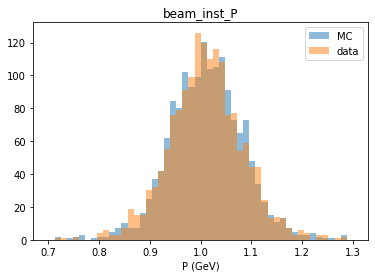

In [4]:
nmc = len(mcP); ndata = len(dataP)
print("MC selected events:", nmc, "\tData selected events:", ndata)
mcweight = np.ones_like(mcP)*ndata/nmc
print("Cut:", precut + f" & (Beam Quality Cut)")

nnmc, xemc, _ = plt.hist(mcP, bins=50, alpha=0.5, label="MC", weights=mcweight, range=[momin,momax])
nndt, xedt, _ = plt.hist(dataP, bins=50, alpha=0.5, label="data", range=[momin,momax])
plt.legend()
plt.title("beam_inst_P")
plt.xlabel("P (GeV)")
plt.show()

In [5]:
def gauss_pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)
def gauss_cdf(xe, mu, sigma):
    return norm.cdf(xe, mu, sigma)

#c1 = cost.UnbinnedNLL(mcP, gauss_pdf)
#c2 = cost.UnbinnedNLL(dataP, gauss_pdf)
c1 = cost.BinnedNLL(nnmc, xemc, gauss_cdf)
c2 = cost.BinnedNLL(nndt, xedt, gauss_cdf)

m1 = Minuit(c1, mu=1, sigma=0.07)
m1.migrad()
mu0 = m1.values["mu"]
sigma0 = m1.values["sigma"]
print(f"MC fitted (mu, sigma) = ({mu0}, {sigma0})")

m2 = Minuit(c2, mu=1, sigma=0.07)
m2.migrad()
muu = m2.values["mu"]
sigmaa = m2.values["sigma"]
print(f"Data fitted (mu, sigma) = ({muu}, {sigmaa})")

MC fitted (mu, sigma) = (1.0116634347354792, 0.0726286545284589)
Data fitted (mu, sigma) = (1.0107418132239876, 0.07238024105332466)


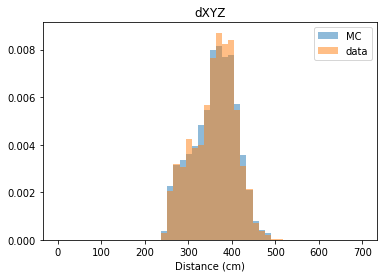

In [6]:
MC_dXYZ = MCdistance[BQcut_MC]
data_dXYZ = datadistance[BQcut_data]

plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC", range=[0,700])
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data", range=[0,700])
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()

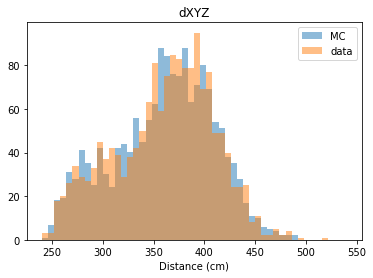

In [7]:
dmin = 240; dmax = 540
nbins = 50 # nbins for dXYZ Chi2 fit
plt.hist(MC_dXYZ, bins=nbins, alpha=0.5, label="MC", weights=mcweight, range=[dmin, dmax])
datahist, bin_edges, _ = plt.hist(data_dXYZ, bins=nbins, alpha=0.5, label="data", range=[dmin, dmax])
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()

deno = np.exp(-(mcP - mu0)**2/2/sigma0**2)
#datahist, bin_edges = np.histogram(data_dXYZ, bins=nbins, range=[dmin, dmax])

def getChi2(mu=muu, sigma=sigmaa):
    numo = np.exp(-(mcP - mu)**2/2/sigma**2)
    weight = numo/deno * mcweight
    MChist, _ = np.histogram(MC_dXYZ, bins=nbins, range=[dmin, dmax], weights=weight)
    chi2 = (datahist - MChist)**2/np.maximum(datahist + MChist, 1)
    return np.sum(chi2)/(nbins-1)

In [8]:
mu_list = np.linspace(1., 1.04, 100)
sigma_list = np.linspace(0.06, 0.09, 100)
mm, ss = np.meshgrid(mu_list, sigma_list)
Chi2 = np.zeros_like(mm)
for i in range(len(mm)):
    for j in range(len(mm[0])):
        Chi2[i,j] = getChi2(mm[i,j], ss[i,j])

Obtained mu = 1.00929 (res 0.0004)
Obtained sigma = 0.07121 (res 0.0003)


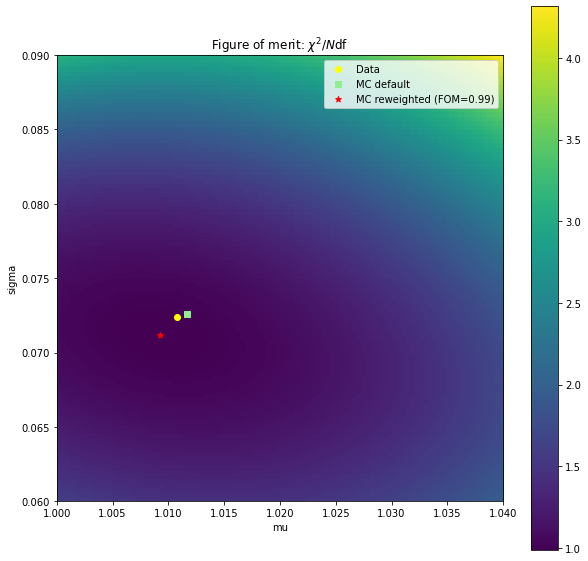

In [9]:
plt.figure(figsize=[10,10])
plt.imshow(Chi2,extent = [min(mu_list),max(mu_list),min(sigma_list),max(sigma_list)],origin="lower",aspect=(max(mu_list)-min(mu_list))/(max(sigma_list)-min(sigma_list)))
plt.colorbar()
plt.title(r"Figure of merit: $\chi^2/N{\rm df}$")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.scatter([muu], [sigmaa], color="yellow", marker="o", label="Data")
plt.scatter([mu0], [sigma0], color="lightgreen", marker="s", label="MC default")
minidx = np.where(Chi2 == np.min(Chi2))
mur = mm[minidx][0]
sigmar = ss[minidx][0]
print(f"Obtained mu = {mur:.5f} (res {np.average(mu_list[1:]-mu_list[:-1]):.2g})")
print(f"Obtained sigma = {sigmar:.5f} (res {np.average(sigma_list[1:]-sigma_list[:-1]):.2g})")
plt.scatter(mur, sigmar, color="r", marker="*", label=f"MC reweighted (FOM={np.min(Chi2):.2f})")
plt.legend()
plt.show()

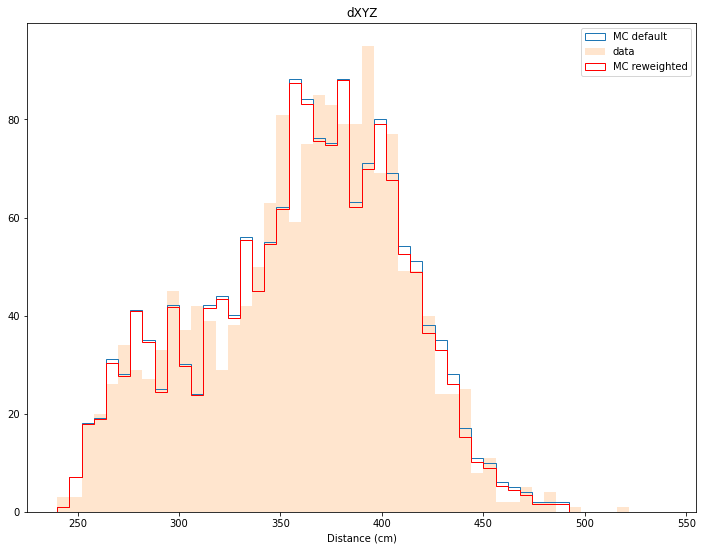

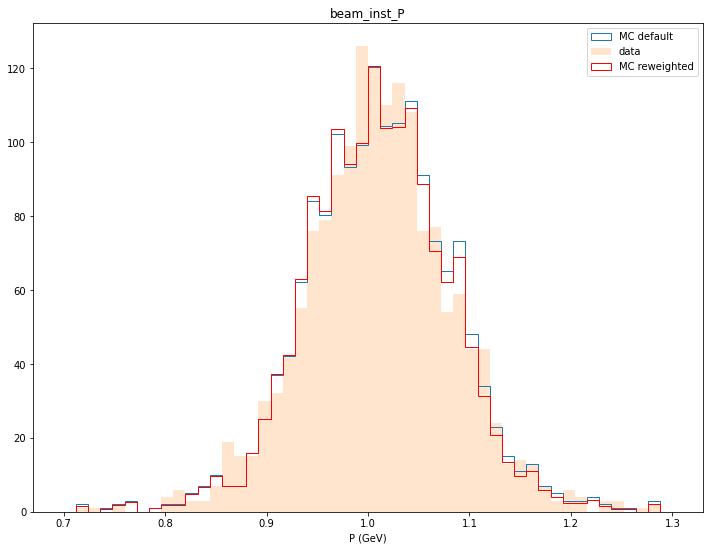

In [10]:
neweight = mcweight * np.exp(-(mcP-mur)**2/2/sigmar**2)/deno
plt.figure(figsize=[12,9])
plt.hist(MC_dXYZ, bins=nbins, histtype="step", label="MC default", weights=mcweight, range=[dmin, dmax])
plt.hist(data_dXYZ, bins=nbins, alpha=0.2, label="data", range=[dmin, dmax])
plt.hist(MC_dXYZ, bins=nbins, histtype="step", label="MC reweighted", weights=neweight, range=[dmin, dmax],color="r")
plt.legend()
plt.title("dXYZ")
plt.xlabel("Distance (cm)")
plt.show()

plt.figure(figsize=[12,9])
plt.hist(mcP, bins=50, histtype="step", label="MC default", weights=mcweight, range=[momin,momax])
plt.hist(dataP, bins=50, alpha=0.2, label="data", range=[momin,momax])
plt.hist(mcP, bins=50, histtype="step", label="MC reweighted", weights=neweight, range=[momin,momax],color="r")
plt.legend()
plt.title("beam_inst_P")
plt.xlabel("P (GeV)")
plt.show()